In [58]:
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB and 'procgen-tools' not in os.getcwd():
    os.system("git clone https://github.com/UlisseMini/procgen-tools")
    os.chdir('procgen-tools')
    %pip install -r requirements.txt

In [63]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import envs.maze as maze
from models import load_policy
import torch
from IPython import display
from glob import glob
import pickle
from tqdm import tqdm
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
def typecheck(l: dict):
    # Typecheck loaded stuff (prevents weird errors lower down if wrong)
    # TODO: Use validation lib (nicer errors)
    assert type(l["level_seed"]) == int
    
    assert isinstance(l["actions"], list)
    assert all(type(a) == int for a in l["actions"])

    assert isinstance(l["rewards"], list)
    assert all(type(r) == float for r in l["rewards"])

    assert isinstance(l["mouse_positions"], list)
    assert all(type(t) == tuple for t in l["mouse_positions"])

    assert isinstance(l["grid"], np.ndarray)

In [74]:
def load_run(file: str, load_venv=False):
    """
    Load a run from a file, optionally load the venv, allowing us to reconstruct the high-def
    image of the maze (stored in run["start_info"]["rgb"])
    (Disabled by default as it's really slow)
    """
    with open(file, 'rb') as f:
        run = pickle.load(f)

    typecheck(run)

    if load_venv:
        venv = ProcgenGym3Env(
            num=1, env_name='maze', num_levels=1, start_level=run["level_seed"],
            distribution_mode='hard', render_mode='rgb_array'
        )
        venv = maze.wrap_venv(venv)
        info = venv.env.get_info()[0]
        assert run["level_seed"] == info["level_seed"], 'level seed doesnt match created env'
        run["start_info"] = info

    return run

In [78]:
files = glob('data/model*ep*.pkl')
for f in files:
    try:
        load_run(f, load_venv=False)
    except (AssertionError, KeyError) as e:
        # delete malformed file
        print(f"Deleting malformed file {f}: {e}")
        os.remove(f)

100%|██████████| 21/21 [00:00<00:00, 95.05it/s]


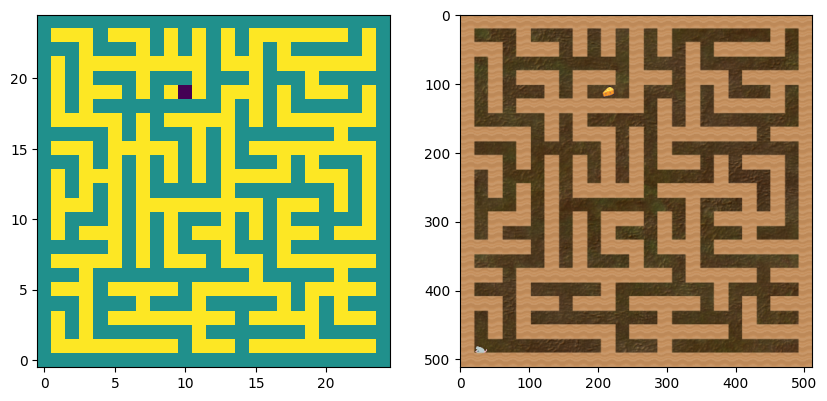

In [79]:
load_venv = True
runs = [load_run(f, load_venv) for f in tqdm(files[:100])]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(runs[0]["grid"], origin='lower')
if load_venv: ax[1].imshow(runs[0]["start_info"]["rgb"])
plt.show()


## Replay a run

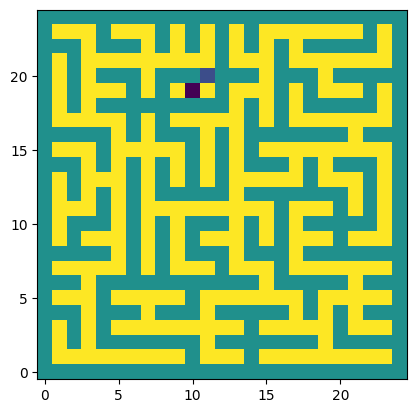

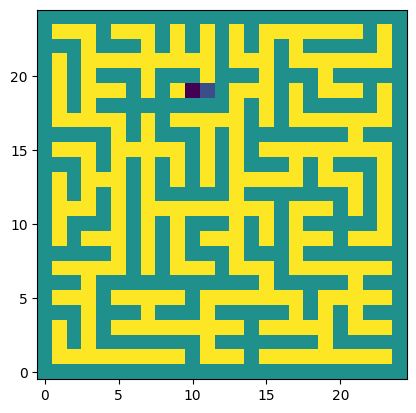

In [84]:
r = runs[0]
for t in range(0, len(r["mouse_positions"])):
    grid = r["grid"].copy()
    mx, my = r["mouse_positions"][t]
    grid[mx, my] = maze.MOUSE
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.imshow(grid, origin='lower')

## Plot distance(mouse, cheese)

In [85]:
for r in runs:
    cx, cy = maze.get_cheese_pos(r['grid'])
    mx, my = r["mouse_positions"][-1]
    print(np.sqrt((cx-mx)**2 + (cy-my)**2)) # 1 = one step away from cheese (win!)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
14.317821063276353
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
2.8284271247461903
2.8284271247461903
1.0
1.0


In [86]:
distances = [0] * 257
nums = [0] * 257
for i, r in enumerate(runs):
    cx, cy = maze.get_cheese_pos(r['grid'])
    for t, (x,y) in enumerate(r["mouse_positions"]): # ignore last pos, as it's a new level
        nums[t] += 1
        distances[t] += np.sqrt((cx-x)**2 + (cy-y)**2)


distances = [distances[i] / max(1,nums[i]) for i in range(len(distances))]

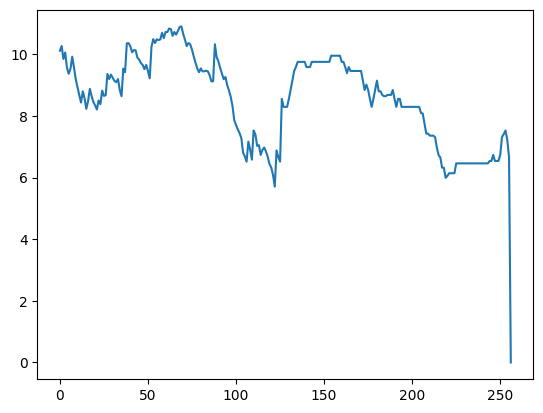

In [87]:
plt.plot(distances)
plt.show()

**Interpretation:** I think the graph is telling us that typically, we either solve the maze relatively quickly, or get stuck and run out of time (rightmost side)